<em> Code for Section 4.2.3, <b>2D Search Space Simulation / Comparison with QP</b> </em>

In [1]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import pyDOE

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import LogConstrainedExpectedImprovement
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls import SumMarginalLogLikelihood

In [2]:
# Suppress warnings

import warnings
from botorch.exceptions import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

Contour plots for four different values of c with QP

In [3]:
# Quadratic penalty function
def quadratic_penalty(x, penalty_param):
    obj = objective_function(x)
    constraint = constraint_function(x)
    penalty = torch.where(constraint > 0, constraint**2, torch.zeros_like(constraint))
    return obj - penalty_param * penalty

In [4]:
def f(x):
    return torch.cos(2 * x[..., 0]) * torch.cos(x[..., 1]) + torch.sin(x[..., 0]) # cos(2x) * cos(y) + sin(x)
def g(x):
    return torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5 # cos(x)cos(y) - sin(x)sin(y) <= -0.5

# QP
def p(g_x):
    return torch.max(torch.zeros_like(g_x), g_x)**2 # p(g(x)) = max(0,g(x))^2
def f_p(x, c):
    return f(x) - c * p(g(x)) # f_p(x) = f(x) - c * p(g(x))

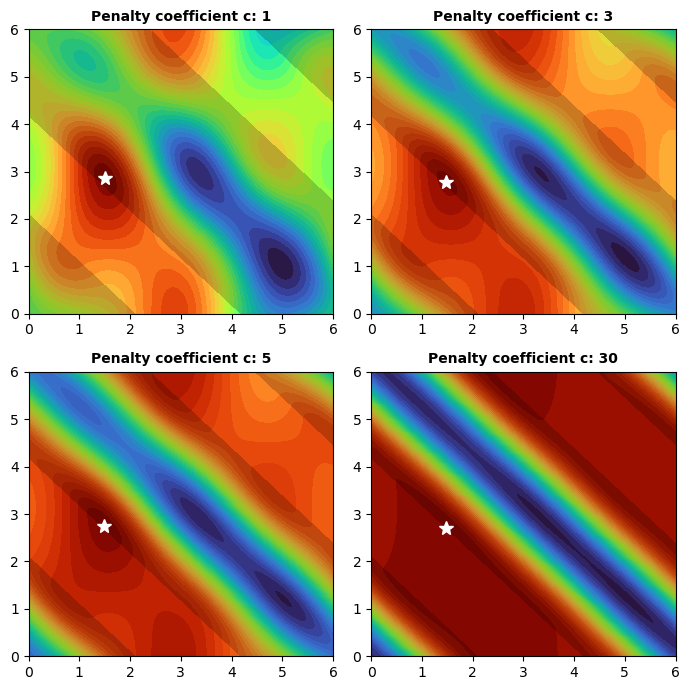

In [5]:
x = np.linspace(0, 6, 200)
y = np.linspace(0, 6, 200)
X, Y = np.meshgrid(x, y)
grid = torch.tensor(np.stack([X, Y], axis=-1))
penalty_coefficients = [1, 3, 5, 30]
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs = axs.ravel()

for i, c in enumerate(penalty_coefficients):
    Z = f_p(grid, c).numpy()
    cs = axs[i].contourf(X, Y, Z, levels=35, cmap='turbo')
    axs[i].set_title(f'Penalty coefficient c: {c}', fontsize=10, fontweight='bold')
    constraint = g(grid).numpy()

    axs[i].contourf(X, Y, constraint, levels=[0, np.max(constraint)], colors='black', alpha=0.2)
    
    max_idx = np.unravel_index(np.argmax(Z), Z.shape)
    max_x, max_y = X[max_idx], Y[max_idx]
    axs[i].plot(max_x, max_y, 'w*', markersize=10, label=f'Max: ({max_x:.2f}, {max_y:.2f})')
plt.tight_layout()
plt.show()


Best obj. values found with QP vs constraint violation for different values of c

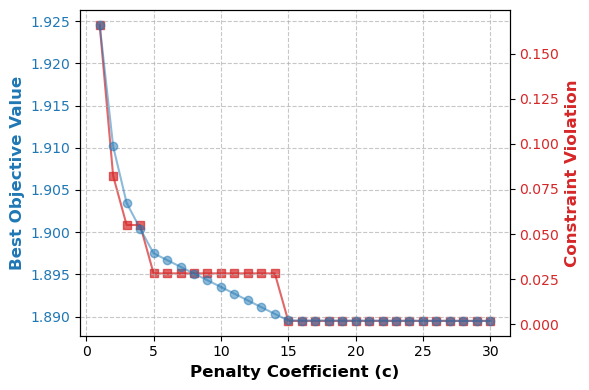

In [6]:
x = np.linspace(0, 6, 200)
y = np.linspace(0, 6, 200)
X, Y = np.meshgrid(x, y)

grid = torch.tensor(np.stack([X, Y], axis=-1))

penalty_coefficients = range(1, 31)

max_values = []
constraint_violations = []

for c in penalty_coefficients:
    Z = f_p(grid, c).numpy()
    max_idx = np.unravel_index(np.argmax(Z), Z.shape)
    max_value = np.max(Z)
    max_values.append(max_value)
    max_point = grid[max_idx[0], max_idx[1]]
    constraint_value = g(max_point).item()
    constraint_violations.append(max(0, constraint_value))

fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:blue'
ax1.set_xlabel('Penalty Coefficient (c)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Best Objective Value', color=color, fontsize=12, fontweight='bold')
ax1.plot(penalty_coefficients, max_values, color=color, marker='o', zorder=3, alpha=0.5) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
ax2.set_zorder(1) 

color = 'tab:red'
ax2.set_ylabel('Constraint Violation', color=color, fontsize=12, fontweight='bold')
ax2.plot(penalty_coefficients, constraint_violations, color=color, marker='s', zorder=2, alpha=0.7) 
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_zorder(2)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.patch.set_visible(False)

fig.tight_layout()
plt.show()


BO on Penalised f(x,y)

In [7]:
# Latin Hypercube Sampling 

def latin_hypercube_sampling(n_samples, dim, bounds):
    lhs_samples = pyDOE.lhs(dim, samples=n_samples)
    lhs_samples += np.random.uniform(0, 1/n_samples, lhs_samples.shape)
    lhs_samples = np.clip(lhs_samples, 0, 1)
    bounds_np = np.array(bounds)
    scaled_samples = lhs_samples * (bounds_np[1] - bounds_np[0]) + bounds_np[0]
    return torch.tensor(scaled_samples, dtype=torch.float64)

In [26]:
def objective_function(x):
    f = torch.cos(2 * x[..., 0]) * torch.cos(x[..., 1]) + torch.sin(x[..., 0])

    g = torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5
    
    c = 16
    
    penalty = c * torch.max(torch.zeros_like(g), g)**2
    
    f_p = f - penalty
    
    return f_p

# Constraint function
def constraint_function(x):
    return torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5

In [27]:
dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_initial = 5
n_iterations = 25
batch_size = 1 

In [31]:
# Initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)

In [32]:
# Optimisation loop

for i in range(n_iterations):
    
    # Fitting the model
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Acquisition function
    # UCB = UpperConfidenceBound(model=model, beta=2.0)
    
    EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # evaluate obkective at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)

    # append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: 1.800370693206787
Iteration 2: Best value so far: 1.800370693206787
Iteration 3: Best value so far: 1.800370693206787
Iteration 4: Best value so far: 1.800370693206787
Iteration 5: Best value so far: 1.800370693206787
Iteration 6: Best value so far: 1.800370693206787
Iteration 7: Best value so far: 1.800370693206787
Iteration 8: Best value so far: 1.800370693206787
Iteration 9: Best value so far: 1.800370693206787
Iteration 10: Best value so far: 1.800370693206787
Iteration 11: Best value so far: 1.800370693206787
Iteration 12: Best value so far: 1.800370693206787
Iteration 13: Best value so far: 1.800370693206787
Iteration 14: Best value so far: 1.800370693206787
Iteration 15: Best value so far: 1.800370693206787
Iteration 16: Best value so far: 1.800370693206787
Iteration 17: Best value so far: 1.800370693206787
Iteration 18: Best value so far: 1.800370693206787
Iteration 19: Best value so far: 1.800370693206787
Iteration 20: Best value so far: 1.80037

Total number of points: 30
Number of points inside the feasible region: 19
Best value found: 1.800370693206787
Best parameters: [1.311659574508667, 2.857102394104004]


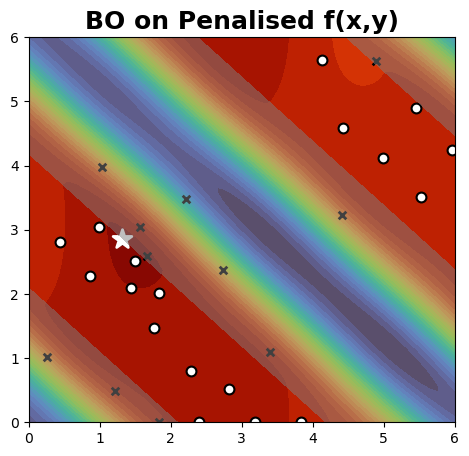

In [33]:
# Create a grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

plt.figure(figsize=(5.5, 5))


contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)


total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.title('BO on Penalised f(x,y)', fontweight='bold', fontsize=18)
plt.show()


Comparison of 6 independent runs of pBO


Run 1 results:
Total number of points: 15
Number of points inside the feasible region: 10
Best value found: 1.091636061668396
Best parameters: [2.7774555683135986, 0.1705748736858368]

Run 2 results:
Total number of points: 15
Number of points inside the feasible region: 8
Best value found: 1.0950979456834957
Best parameters: [1.463735410367927, 1.6741600575270934]

Run 3 results:
Total number of points: 15
Number of points inside the feasible region: 10
Best value found: 1.516848936656909
Best parameters: [1.1294891907164493, 2.874745590468903]

Run 4 results:
Total number of points: 15
Number of points inside the feasible region: 9
Best value found: 1.667986512184143
Best parameters: [1.3907866477966309, 2.93205189704895]

Run 5 results:
Total number of points: 15
Number of points inside the feasible region: 7
Best value found: 1.0874032820690362
Best parameters: [2.8373406659330866, 6.0]

Run 6 results:
Total number of points: 15
Number of points inside the feasible region: 9
Best 

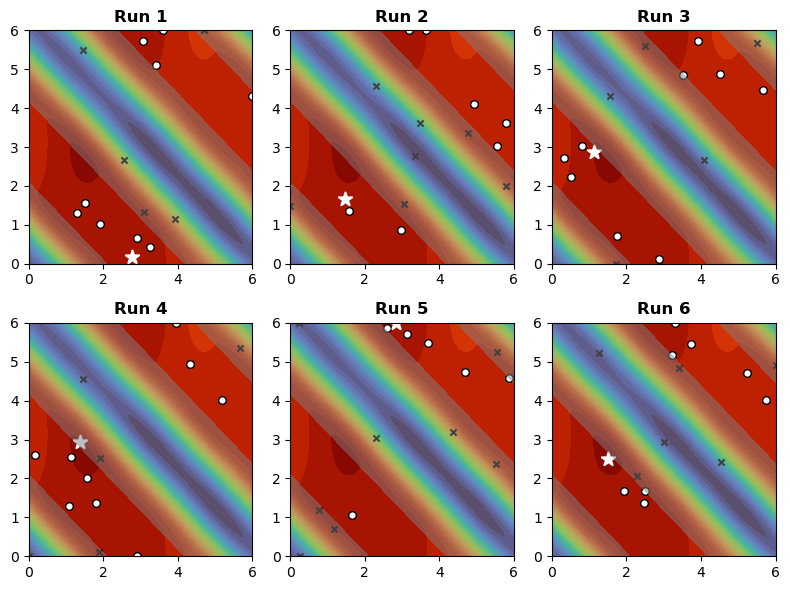

In [54]:
def run_bo_and_plot(ax, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    dim = 2
    bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
    n_initial = 5
    n_iterations = 10
    batch_size = 1 

    train_X = latin_hypercube_sampling(n_initial, dim, bounds)
    train_Y = objective_function(train_X).unsqueeze(-1)

    # optimisation loop
    for i in range(n_iterations):
        model = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        EI = LogExpectedImprovement(model=model, best_f=train_Y.max())
        candidates, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=batch_size,
            num_restarts=40,
            raw_samples=1024,
        )
        new_Y = objective_function(candidates).unsqueeze(-1)
        train_X = torch.cat([train_X, candidates])
        train_Y = torch.cat([train_Y, new_Y])



    # Plotting
    x1 = np.linspace(0, 6, 100)
    x2 = np.linspace(0, 6, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float()
    Y = objective_function(X).numpy().reshape(X1.shape)

    contour = ax.contourf(X1, X2, Y, levels=35, cmap='turbo')

    for i in range(len(train_X)):
        if constraint_function(train_X[i]).item() < 0:
            ax.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=30, linewidth=1)
        else:
            ax.scatter(train_X[i, 0], train_X[i, 1], c='black', s=20, marker='x', linewidth=1.5)

    best_idx = train_Y.argmax()
    ax.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=100, marker='*', linewidth=1.5)

    Z = constraint_function(X).numpy().reshape(X1.shape)
    ax.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)

    ax.set_title(f'Run {seed + 1}', fontweight='bold', fontsize=12)
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)

    return train_X, train_Y

fig, axs = plt.subplots(2, 3, figsize=(8, 6))

for i, ax in enumerate(axs.flatten()):
    train_X, train_Y = run_bo_and_plot(ax, i)
    
    # Print results for each run
    print(f"\nRun {i + 1} results:")
    print(f"Total number of points: {len(train_X)}")
    feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
    print(f"Number of points inside the feasible region: {feasible_count}")
    print(f"Best value found: {train_Y.max().item()}")
    print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.tight_layout()
plt.show()

pBO with c=30

Iteration 1: Best value so far: -0.985730869860071
Iteration 2: Best value so far: -0.985730869860071
Iteration 3: Best value so far: -0.985730869860071
Iteration 4: Best value so far: -0.4115619659423828
Iteration 5: Best value so far: -0.4115619659423828
Iteration 6: Best value so far: 1.0051897764205933
Iteration 7: Best value so far: 1.0051897764205933
Iteration 8: Best value so far: 1.0051897764205933
Iteration 9: Best value so far: 1.0051897764205933
Iteration 10: Best value so far: 1.0051897764205933
Iteration 11: Best value so far: 1.0051897764205933
Iteration 12: Best value so far: 1.313822865486145
Iteration 13: Best value so far: 1.313822865486145
Iteration 14: Best value so far: 1.313822865486145
Iteration 15: Best value so far: 1.313822865486145
Iteration 16: Best value so far: 1.313822865486145
Iteration 17: Best value so far: 1.313822865486145
Iteration 18: Best value so far: 1.313822865486145
Iteration 19: Best value so far: 1.313822865486145
Iteration 20: Best value so

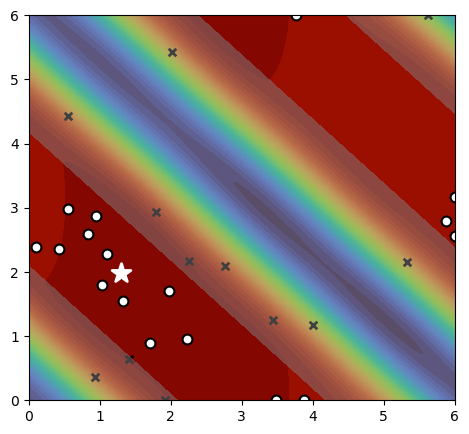

In [68]:
def objective_function(x):
    f = torch.cos(2 * x[..., 0]) * torch.cos(x[..., 1]) + torch.sin(x[..., 0])

    g = torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5
    
    c = 30
    
    penalty = c * torch.max(torch.zeros_like(g), g)**2
    
    f_p = f - penalty
    
    return f_p

dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_initial = 5
n_iterations = 25
batch_size = 1 

# %%
# Initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)

# %%
# Optimisation loop

for i in range(n_iterations):
    
    # Fitting the model
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Acquisition function
    # UCB = UpperConfidenceBound(model=model, beta=2.0)
    
    EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # evaluate obkective at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)

    # append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

# %%
# Create a grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

plt.figure(figsize=(5.5, 5))


contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)


total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.show()

Comparison of GP mean and uncertainty of BO on penalised f(x,y)

<small>Similarly applied to cBO (code not included)</small>

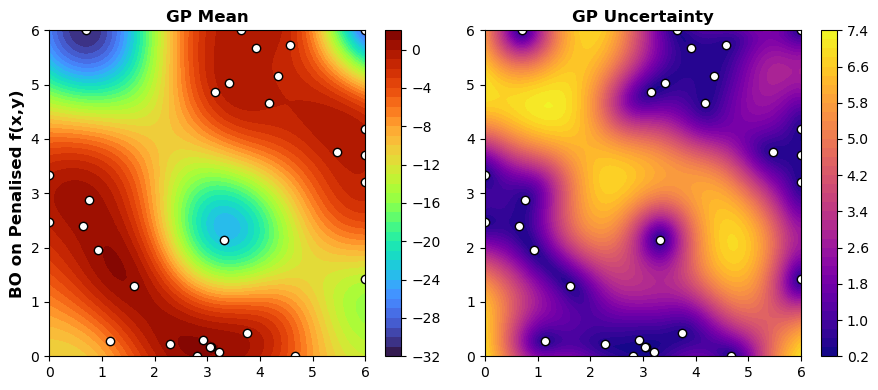

In [13]:
# Plot GP Mean and Uncertainty Contour Plots
# Ensure the model is trained
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# Get GP posterior mean and uncertainty
with torch.no_grad():
    posterior = model.posterior(X)
    mean = posterior.mean.numpy().reshape(X1.shape)  # GP mean
    stddev = posterior.stddev.numpy().reshape(X1.shape)  # GP uncertainty


fig, axes = plt.subplots(1, 2, figsize=(9, 4))

contour_mean = axes[0].contourf(X1, X2, mean, cmap='turbo', levels=35)
fig.colorbar(contour_mean, ax=axes[0])
axes[0].scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c='white', edgecolors='black', label='Evaluated Points')
axes[0].set_title('GP Mean', fontweight='bold')
axes[0].set_ylabel('BO on Penalised f(x,y)', fontweight='bold', fontsize=12)

contour_uncertainty = axes[1].contourf(X1, X2, stddev, cmap='plasma', levels=35)
fig.colorbar(contour_uncertainty, ax=axes[1])
axes[1].scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c='white', edgecolors='black', label='Evaluated Points')
axes[1].set_title('GP Uncertainty', fontweight='bold')

plt.tight_layout()
plt.show()
